In [1]:
import os
import sys

import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)


from src.utils import IATAProcessor
processor = IATAProcessor(custom_stopwords=["iata", "aviation", "air", "industry", "iatas", "airlines", "aircraft", "billion", "million", "travel"])

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

c:\Users\kruu\git_folder\iata_recommendation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kruu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kruu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


****
# Topic Extraction
****

Processing tasks:
- Extract text from pdf
- Chunk text into group of sentences (default 5) using sent_tokenize
- Clean chunks by converting to lowercases, removing ponctuation and stopwords

Embedding:
- Using HugginFace MiniLM-L6-v2

Topic Modeling:
- Use BERTopic
- First dimensionality reduction using UMAP
- Then HDBSCAN for clustering chunks with similar semantics
- Finaly TF-IDF to rank keywords that represent each topic
- Using vectorizer in BERTopi to specify how to turn the clean text into a bag-of-words representation for keyword representation.

In [2]:
data_dir = Path("../data")
pdf_files = sorted(data_dir.glob("iata-annual-review-*.pdf"))

yearly_topic_data = []

for pdf in pdf_files:
    year_match = re.search(r"(\d{4})", pdf.stem)
    if not year_match:
        continue
    year = int(year_match.group(1))

    print(f"Processing {pdf.name} for year {year}")
    cleaned_chunks = processor.preprocess_pdf(pdf, chunk_size=5)
    embeddings = embedding_model.encode(cleaned_chunks, show_progress_bar=True)

    vectorizer = CountVectorizer(stop_words=list(processor.stopwords))
    topic_model = BERTopic(vectorizer_model=vectorizer, verbose=False)
    topics, _ = topic_model.fit_transform(cleaned_chunks, embeddings)
    
    topic_keywords = {
        topic_id: ", ".join([word for word, _ in topic_model.get_topic(topic_id)])
        for topic_id in set(topics)
        if topic_id != -1  # exclude outlier topic
    }

    df = pd.DataFrame({
        "year": [year] * len(cleaned_chunks),
        "chunk": cleaned_chunks,
        "topic": topics
    })
    
    print(f"Proportion of unassigned chunks: {len(df[df.topic == -1]) / len(cleaned_chunks)}", end = "\n\n")
    
    df = df[df.topic != -1]  # Remove outliers

    df["topic_label"] = df["topic"].map(topic_keywords)
    
    yearly_topic_data.append((year, topic_model, df))


Processing iata-annual-review-2005.pdf for year 2005


Batches: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Proportion of unassigned chunks: 0.4375

Processing iata-annual-review-2006.pdf for year 2006


Batches: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Proportion of unassigned chunks: 0.18238993710691823

Processing iata-annual-review-2007.pdf for year 2007


Batches: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Proportion of unassigned chunks: 0.14388489208633093

Processing iata-annual-review-2008.pdf for year 2008


Batches: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Proportion of unassigned chunks: 0.0

Processing iata-annual-review-2009.pdf for year 2009


Batches: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Proportion of unassigned chunks: 0.0

Processing iata-annual-review-2010.pdf for year 2010


Batches: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Proportion of unassigned chunks: 0.0

Processing iata-annual-review-2011.pdf for year 2011


Batches: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]


Proportion of unassigned chunks: 0.0

Processing iata-annual-review-2012.pdf for year 2012


Batches: 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


Proportion of unassigned chunks: 0.0

Processing iata-annual-review-2013.pdf for year 2013


Batches: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Proportion of unassigned chunks: 0.07725321888412018

Processing iata-annual-review-2014.pdf for year 2014


Batches: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


Proportion of unassigned chunks: 0.32673267326732675

Processing iata-annual-review-2015.pdf for year 2015


Batches: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Proportion of unassigned chunks: 0.0

Processing iata-annual-review-2016.pdf for year 2016


Batches: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Proportion of unassigned chunks: 0.3165829145728643

Processing iata-annual-review-2017.pdf for year 2017


Batches: 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]


Proportion of unassigned chunks: 0.1588235294117647

Processing iata-annual-review-2018.pdf for year 2018


Batches: 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]


Proportion of unassigned chunks: 0.31137724550898205

Processing iata-annual-review-2019.pdf for year 2019


Batches: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Proportion of unassigned chunks: 0.1348314606741573

Processing iata-annual-review-2020.pdf for year 2020


Batches: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Proportion of unassigned chunks: 0.3795620437956204

Processing iata-annual-review-2021.pdf for year 2021


Batches: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]


Proportion of unassigned chunks: 0.3

Processing iata-annual-review-2022.pdf for year 2022


Batches: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


Proportion of unassigned chunks: 0.28865979381443296

Processing iata-annual-review-2023.pdf for year 2023


Batches: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Proportion of unassigned chunks: 0.0

Processing iata-annual-review-2024.pdf for year 2024


Batches: 100%|██████████| 6/6 [00:03<00:00,  1.98it/s]


Proportion of unassigned chunks: 0.0



In [3]:
from collections import defaultdict, Counter

# year -> Counter of words (with frequency from repeated labels)
yearly_word_counts = defaultdict(Counter)

for year, model, df in yearly_topic_data:
    # Count how many times each topic_label appears
    label_counts = df["topic_label"].value_counts()
    
    for label, count in label_counts.items():
        words = label.lower().split(", ")
        for word in words:
            yearly_word_counts[year][word] += count
            
for year in sorted(yearly_word_counts):
    print(f"{year} — Top Words:")
    for word, count in yearly_word_counts[year].most_common(5):
        print(f"   {word}: {count}", end = "\n")

2005 — Top Words:
   new: 56
   business: 35
   airline: 35
   safety: 33
   security: 33
2006 — Top Words:
   safety: 69
   security: 69
   cargo: 69
   data: 69
   service: 69
2007 — Top Words:
   fuel: 57
   emissions: 57
   charges: 57
   years: 57
   cost: 57
2008 — Top Words:
   passenger: 141
   safety: 121
   new: 121
   airports: 121
   cargo: 121
2009 — Top Words:
   fuel: 137
   cargo: 137
   security: 137
   savings: 137
   new: 137
2010 — Top Words:
   safety: 128
   cargo: 128
   airports: 128
   global: 128
   program: 128
2011 — Top Words:
   safety: 140
   security: 140
   program: 140
   global: 140
   airports: 140
2012 — Top Words:
   airline: 174
   global: 153
   safety: 153
   passenger: 153
   security: 153
2013 — Top Words:
   passenger: 140
   fuel: 109
   cargo: 106
   security: 106
   passengers: 106
2014 — Top Words:
   passenger: 57
   fuel: 43
   emissions: 30
   icao: 30
   global: 30
2015 — Top Words:
   cargo: 200
   passenger: 200
   safety: 200
   gl

****
# Grouping similar Topic ID through semantics
****

Evaluate topic evolution:
- Create embeddings on the previously found topic ids for all years
- Group similar embeddings with Kmeans

In [48]:
encoder = SentenceTransformer("all-MiniLM-L6-v2")

unique_topics = []

for year, model, df in yearly_topic_data:
    for topic_id, label in df[["topic", "topic_label"]].drop_duplicates().values:
        unique_topics.append((year, topic_id, label))

In [60]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

vectors = [encoder.encode(label) for (_, _, label) in unique_topics]
vectors_norm = normalize(vectors, norm='l2')

best_k = None
best_score = -1
best_model = None

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    group_ids = kmeans.fit_predict(vectors_norm)
    score = silhouette_score(vectors_norm, group_ids)
    # print(f"k={k}, silhouette_score={score:.3f}")
    
    if score > best_score:
        best_k = k
        best_score = score
        best_model = kmeans

print(f"Best k = {best_k} with silhouette score = {best_score:.3f}")

group_ids = best_model.labels_

Best k = 8 with silhouette score = 0.134


In [61]:
# Create mapping: (year, topic_id) to meta-topic group_id
topic_to_meta = {
    (year, topic_id): group_id
    for (year, topic_id, _), group_id in zip(unique_topics, group_ids)
}

meta_topic_df = pd.concat([
    df.assign(group_id=df["topic"].map(lambda tid: topic_to_meta.get((year, tid))))
    for year, model, df in yearly_topic_data
])

# Count per year
evolution = meta_topic_df.groupby(["group_id", "year"]).size().unstack().fillna(0)

<Figure size 2000x600 with 0 Axes>

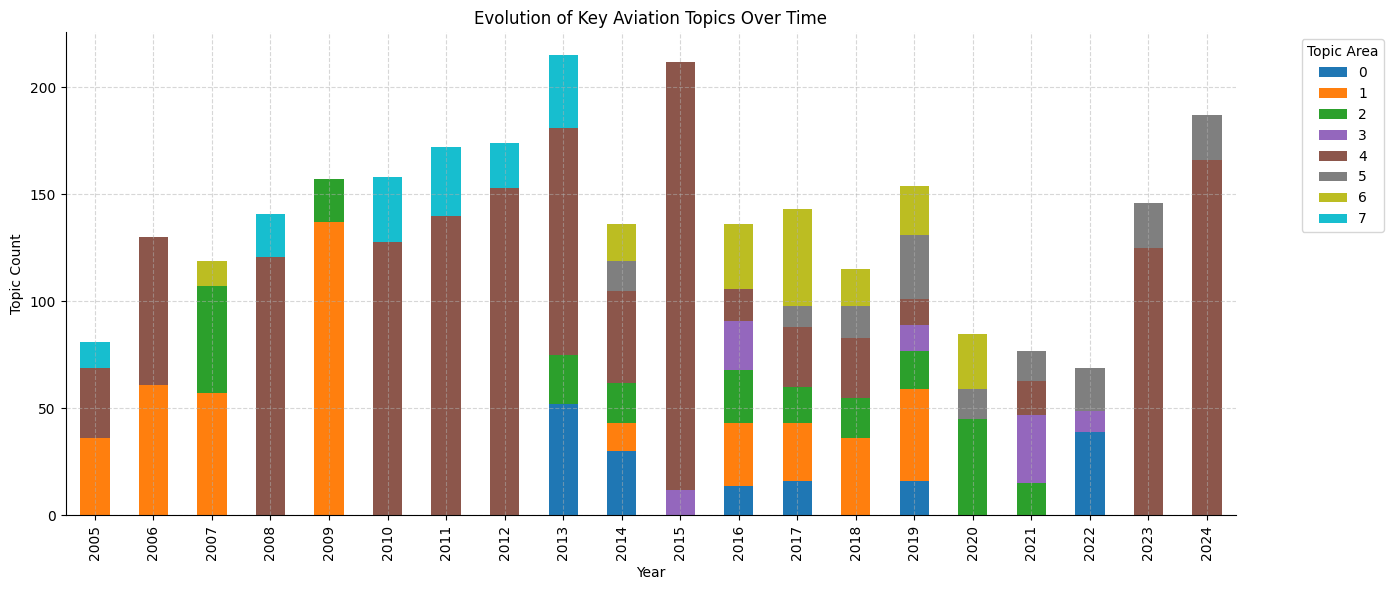

In [62]:
group_labels = meta_topic_df.groupby("group_id")["topic_label"].agg(lambda x: x.value_counts().index[0]).to_dict()

plt.figure(figsize=(20, 6))
evolution.T.rename(index=group_labels).plot(
    kind="bar", stacked=True, figsize=(14, 6),
    colormap="tab10"
)
plt.title("Evolution of Key Aviation Topics Over Time")
plt.xlabel("Year")
plt.ylabel("Topic Count")
plt.legend(title="Topic Area", bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha = 0.5, linestyle = "--")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()
plt.show()

In [63]:
group_labels = meta_topic_df.groupby("group_id")["topic_label"].agg(lambda x: x.value_counts().index[0])
for i, group in enumerate(group_labels):
    print(f"{i}: {group}", end = "\n\n")

0: emissions, fuel, european, charges, airport, airports, icao, environmental, scheme, new

1: fuel, cargo, security, savings, new, global, passenger, airports, international, airline

2: safety, cargo, security, management, data, iosa, accidents, airline, operations, flight

3: executive, officer, chief, saf, governments, emissions, aid, chairman, government, demand

4: cargo, passenger, safety, global, security, airline, airport, fuel, airports, passengers

5: cargo, economics, growth, jul, yoy, demand, global, international, source, sustainability

6: cargo, data, solutions, ndc, global, settlement, order, iss, program, tact

7: growth, markets, economic, freight, fuel, passenger, profits, market, load, business

